In [1]:
import pandas as pd
import numpy as np
pd.options.display.precision = 15
from sklearn.linear_model import LinearRegression
from scipy.signal import hilbert,convolve,hann
from scipy import stats
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
%time
tr_data = pd.read_csv('train.csv',dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [3]:
sample_len = 150000
n_tr = int(np.floor(tr_data.shape[0] / sample_len))
n_tr

4194

In [4]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [5]:
X = pd.DataFrame(index = range(n_tr), 
                      columns = ['mean','std','max','min',
                                 'Rmean','Rstd','Rmax','Rmin',
                                 'Imean','Istd','Imax','Imin',
                                 'Rmean_last_5000','Rstd_last_5000',
                                 'Rmax_last_5000','Rmin_last_5000',
                                 'Rmean_last_15000','Rstd_last_15000',
                                 'Rmax_last_15000','Rmin_last_15000',
                                 'mean_change_abs','mean_change_rate',
                                 'abs_max','abs_min',
                                 'std_first_50000','std_last_50000',
                                 'std_first_10000','std_last_10000',
                                 'avg_first_50000','avg_last_50000',
                                 'avg_first_10000','avg_last_10000',
                                 'min_first_50000','min_last_50000',
                                 'min_first_10000','min_last_10000',
                                 'max_first_50000','max_last_50000',
                                 'max_first_10000','max_last_10000',
                                 'max_to_min','max_to_min_diff',
                                 'count_big','sum',
                                 'mean_change_rate_first_50000',
                                 'mean_change_rate_last_50000',
                                 'mean_change_rate_first_10000',
                                 'mean_change_rate_last_10000',
                                 'q95','q99','q05','q01',
                                 'abs_q95','abs_q99','abs_q05','abs_q01',
                                 'trend','abs_trend','abs_mean','abs_std',
                                 'mad','kurt','skew','med',
                                 'Hilbert_mean','Hann_window_mean',
                                 'classic_Sta_lta1_mean',
                                 'classic_Sta_lta2_mean',
                                 'classic_Sta_lta3_mean',
                                 'classic_Sta_lta4_mean',
                                 'Moving_average_700_mean',
                                 'Moving_average_1500_mean',
                                 'Moving_average_3000_mean',
                                 'Moving_average_6000_mean',
                                 'exp_Moving_avg_300_mean',
                                 'exp_Moving_avg_3000_mean',
                                 'exp_Moving_avg_30000_mean',
                                 'MA_700MA_std_mean',
                                 'MA_700_BB_high_mean',
                                 'MA_700_BB_low_mean',
                                 'MA_400MA_std_mean',
                                 'MA_400_BB_high_mean',
                                 'MA_400_BB_low_mean',
                                 'MA_1000MA_std_mean',
                                 'iqr','q999','q001','ave10',
                                 'ave_roll_std_','std_roll_std_',
                                 'max_roll_std_','min_roll_std_',
                                 'q01_roll_std_','q05_roll_std_',
                                 'q95_roll_std_','q99_roll_std_',
                                 'av_change_abs_roll_std_',
                                 'av_change_rate_roll_std_',
                                 'abs_max_roll_std_',
                                 'ave_roll_mean_',
                                 'std_roll_mean_',
                                 'max_roll_mean_','min_roll_mean_',
                                 'q01_roll_mean_','q01_roll_mean_',
                                 'q95_roll_mean_','q99_roll_mean_',
                                 'av_change_abs_roll_mean_',
                                 'av_change_rate_roll_mean_',
                                 'abs_max_roll_mean_'
                                ])

Y = pd.DataFrame(index = range(n_tr), columns = ['time_to_failure'])

In [17]:
for seg_id in tqdm_notebook(X.index):
    if seg_id % 100 == 0:
        print(seg_id)
    
    segment = tr_data.iloc[seg_id*sample_len : seg_id*sample_len + sample_len]
    Y.loc[seg_id, 'time_to_failure'] = segment['time_to_failure'].values[-1]
    
    xc = pd.Series(segment['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id,'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = np.mean(X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean'])
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = np.mean(X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean'])
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = np.mean(X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean'])
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = np.mean(X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean'])
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    

0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

700


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

800


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

900


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1000


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


1300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1700


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1800


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1900


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2000


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide


2100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2700


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2800


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2900


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3000


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/l

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


3600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3700


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3800


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

3900


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


4000


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

4100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide


In [19]:
X.shape

(4194, 189)

In [20]:
X.to_csv('new_features.csv',index = False)
Y.to_csv('new_labels_features.csv',index=False)

### Test set

In [2]:
submission = pd.read_csv('sample_submission.csv')
segment_id = submission['seg_id']
n_test = len(segment_id)
n_test

2624

### Features for test data

In [29]:
X_test = pd.DataFrame(index = range(n_test), 
                      columns = ['mean','std','max','min',
                                 'Rmean','Rstd','Rmax','Rmin',
                                 'Imean','Istd','Imax','Imin',
                                 'Rmean_last_5000','Rstd_last_5000',
                                 'Rmax_last_5000','Rmin_last_5000',
                                 'Rmean_last_15000','Rstd_last_15000',
                                 'Rmax_last_15000','Rmin_last_15000',
                                 'mean_change_abs','mean_change_rate',
                                 'abs_max','abs_min',
                                 'std_first_50000','std_last_50000',
                                 'std_first_10000','std_last_10000',
                                 'avg_first_50000','avg_last_50000',
                                 'avg_first_10000','avg_last_10000',
                                 'min_first_50000','min_last_50000',
                                 'min_first_10000','min_last_10000',
                                 'max_first_50000','max_last_50000',
                                 'max_first_10000','max_last_10000',
                                 'max_to_min','max_to_min_diff',
                                 'count_big','sum',
                                 'mean_change_rate_first_50000',
                                 'mean_change_rate_last_50000',
                                 'mean_change_rate_first_10000',
                                 'mean_change_rate_last_10000',
                                 'q95','q99','q05','q01',
                                 'abs_q95','abs_q99','abs_q05','abs_q01',
                                 'trend','abs_trend','abs_mean','abs_std',
                                 'mad','kurt','skew','med',
                                 'Hilbert_mean','Hann_window_mean',
                                 'classic_Sta_lta1_mean',
                                 'classic_Sta_lta2_mean',
                                 'classic_Sta_lta3_mean',
                                 'classic_Sta_lta4_mean',
                                 'Moving_average_700_mean',
                                 'Moving_average_1500_mean',
                                 'Moving_average_3000_mean',
                                 'Moving_average_6000_mean',
                                 'exp_Moving_avg_300_mean',
                                 'exp_Moving_avg_3000_mean',
                                 'exp_Moving_avg_30000_mean',
                                 'MA_700MA_std_mean',
                                 'MA_700_BB_high_mean',
                                 'MA_700_BB_low_mean',
                                 'MA_400MA_std_mean',
                                 'MA_400_BB_high_mean',
                                 'MA_400_BB_low_mean',
                                 'MA_1000MA_std_mean',
                                 'iqr','q999','q001','ave10',
                                 'ave_roll_std_','std_roll_std_',
                                 'max_roll_std_','min_roll_std_',
                                 'q01_roll_std_','q05_roll_std_',
                                 'q95_roll_std_','q99_roll_std_',
                                 'av_change_abs_roll_std_',
                                 'av_change_rate_roll_std_',
                                 'abs_max_roll_std_',
                                 'ave_roll_mean_',
                                 'std_roll_mean_',
                                 'max_roll_mean_','min_roll_mean_',
                                 'q01_roll_mean_','q01_roll_mean_',
                                 'q95_roll_mean_','q99_roll_mean_',
                                 'av_change_abs_roll_mean_',
                                 'av_change_rate_roll_mean_',
                                 'abs_max_roll_mean_'
                                ])

In [41]:
for seg_id in tqdm_notebook(X_test.index):
    if seg_id % 100 == 0:
        print(seg_id)
    
    segment = pd.read_csv('test/' + segment_id[seg_id] + '.csv')
    
    xc = pd.Series(segment['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X_test.loc[seg_id,'mean'] = xc.mean()
    X_test.loc[seg_id, 'std'] = xc.std()
    X_test.loc[seg_id, 'max'] = xc.max()
    X_test.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X_test.loc[seg_id, 'Rmean'] = realFFT.mean()
    X_test.loc[seg_id, 'Rstd'] = realFFT.std()
    X_test.loc[seg_id, 'Rmax'] = realFFT.max()
    X_test.loc[seg_id, 'Rmin'] = realFFT.min()
    X_test.loc[seg_id, 'Imean'] = imagFFT.mean()
    X_test.loc[seg_id, 'Istd'] = imagFFT.std()
    X_test.loc[seg_id, 'Imax'] = imagFFT.max()
    X_test.loc[seg_id, 'Imin'] = imagFFT.min()
    X_test.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X_test.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X_test.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X_test.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X_test.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X_test.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X_test.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X_test.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X_test.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X_test.loc[seg_id, 'sum'] = xc.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X_test.loc[seg_id, 'mad'] = xc.mad()
    X_test.loc[seg_id, 'kurt'] = xc.kurtosis()
    X_test.loc[seg_id, 'skew'] = xc.skew()
    X_test.loc[seg_id, 'med'] = xc.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = np.mean(X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean'])
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = np.mean(X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean'])
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = np.mean(X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean'])
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = np.mean(X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean'])
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

700


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

800


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

900


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1000


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1700


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1800


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

1900


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2000


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2100


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2200


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2300


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2500


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

2600


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

In [42]:
X_test.shape

(2624, 188)

In [43]:
X_test.to_csv('test_new_features.csv')

### Reading train and test files

In [3]:
X = pd.read_csv('new_features.csv')
Y = pd.read_csv('new_labels_features.csv')
X_test = pd.read_csv('test_new_features.csv')

In [4]:
X.set_index('Unnamed: 0',inplace=True)
X_test.set_index('Unnamed: 0',inplace=True)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb

In [6]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = pd.DataFrame(scaler.transform(X),columns = X.columns)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/extmath.py:771: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count


In [7]:
scaled_test_X = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


#### Model

In [8]:
n_fold = 5
folds = KFold(n_splits=n_fold,shuffle=True,random_state = 42)
train_columns = scaled_X.columns.values

In [9]:
#model Parameters
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [45]:
oof = np.zeros(len(scaled_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()

In [47]:
#run model
for fold_,(trn_idx,val_idx) in enumerate(folds.split(scaled_X,Y)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr,X_val = scaled_X.iloc[trn_idx],scaled_X.iloc[val_idx]
    Y_tr,Y_val = Y.iloc[trn_idx],Y.iloc[val_idx]
    model = lgb.LGBMRegressor(**params,n_estimators = 20000,n_jobs = -1)
    model.fit(X_tr,Y_tr,
             eval_set=[(X_tr,Y_tr),(X_val,Y_val)],
             eval_metric = 'mae',
             verbose = 1000,
             early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, 
                                 num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, 
                                       fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, 
                                 num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95722	valid_1's l1: 2.25735
[2000]	training's l1: 1.56503	valid_1's l1: 2.12836
[3000]	training's l1: 1.33503	valid_1's l1: 2.10413
[4000]	training's l1: 1.15961	valid_1's l1: 2.10168
Early stopping, best iteration is:
[3695]	training's l1: 1.20935	valid_1's l1: 2.10072
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.94999	valid_1's l1: 2.27506
[2000]	training's l1: 1.55867	valid_1's l1: 2.14272
[3000]	training's l1: 1.3318	valid_1's l1: 2.11887
[4000]	training's l1: 1.15776	valid_1's l1: 2.11265
[5000]	training's l1: 1.0143	valid_1's l1: 2.11334
Early stopping, best iteration is:
[4589]	training's l1: 1.06994	valid_1's l1: 2.1122
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95743	valid_1's l1: 2.28121
[2000]	training's l1: 1.57091	valid_1's l1: 2.11954
[3000]	training's l1: 1.34249	valid_1's l1: 2.0

### Feature Importance

In [52]:
import seaborn as sns

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


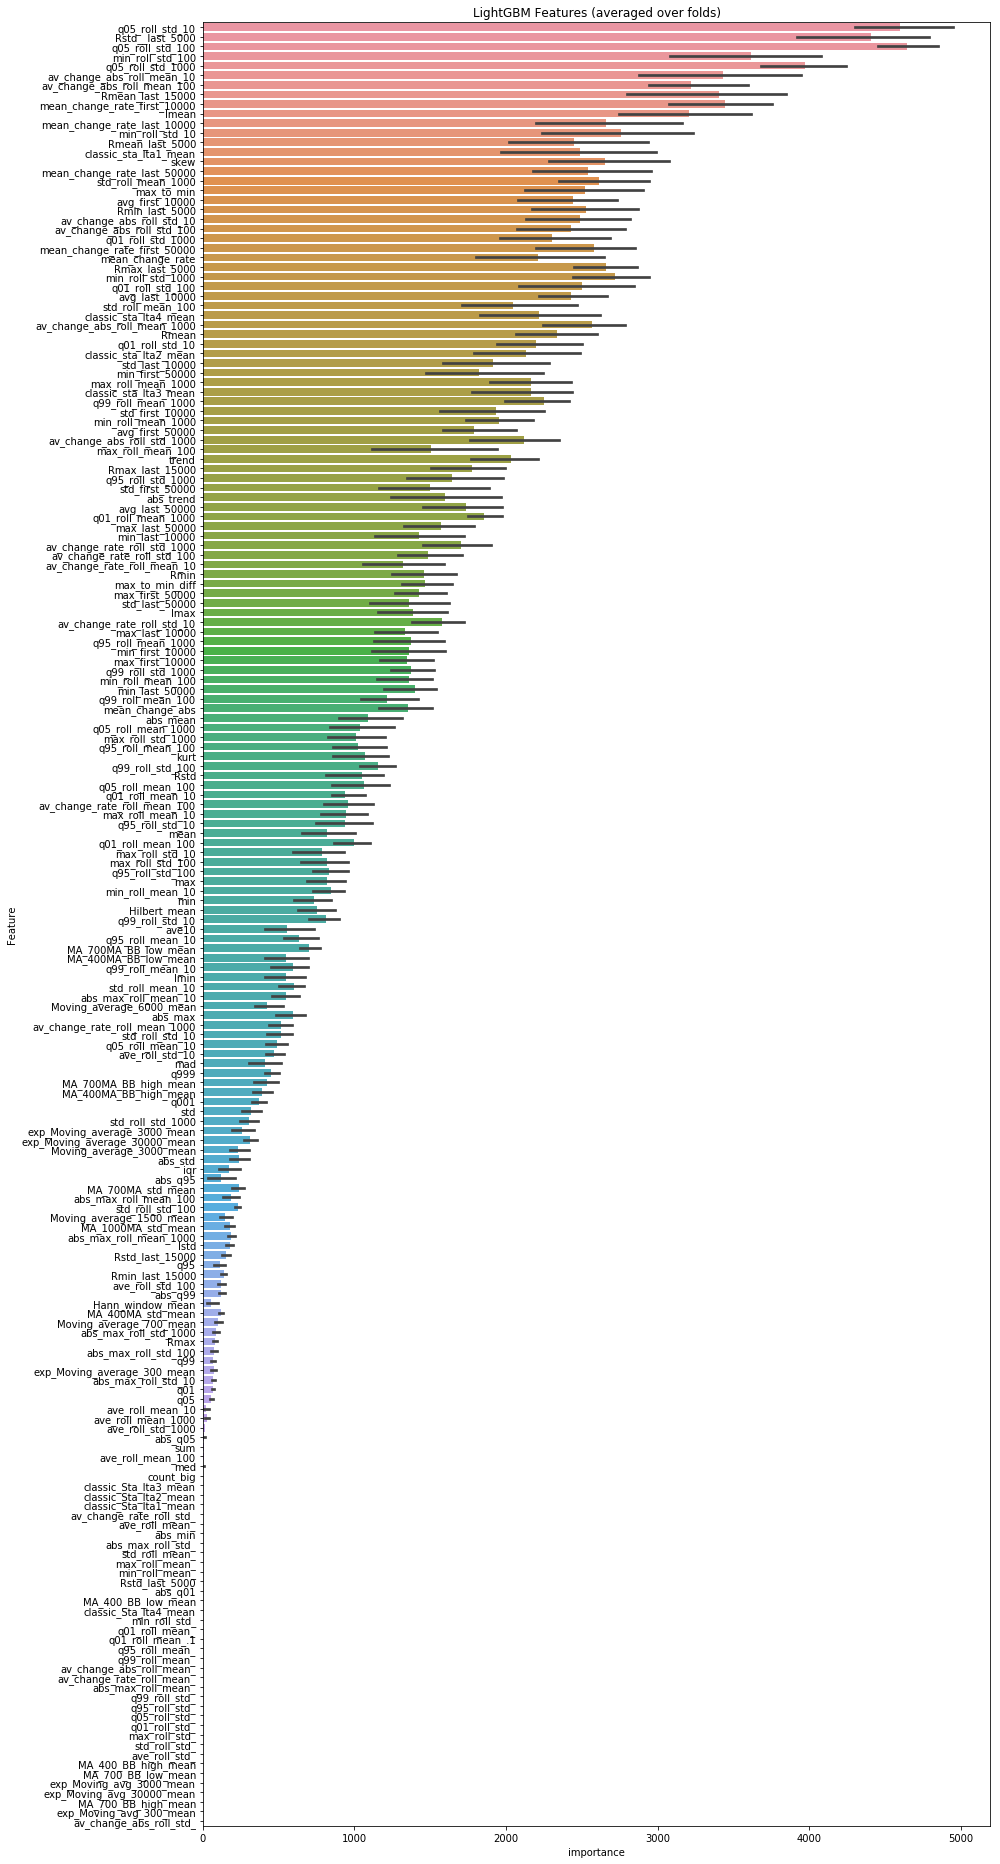

In [53]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### Submission file

In [55]:
submission['time_to_failure'] = predictions
submission.to_csv('sub/LGBM_with_new_features.csv',index=False)
submission.head()

seg_id    time_to_failure
0  seg_00030f  2.969868293558344
1  seg_0012b5  5.519772911938076
2  seg_00184e  5.551305284012830
3  seg_003339  8.596641316859133
4  seg_0042cc  7.017580595328171

In [2]:
from catboost import CatBoostRegressor,Pool,CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [28]:
x_tr,x_va,y_tr,y_va = train_test_split(scaled_X,Y,test_size = 0.4,shuffle = True)

In [26]:
cb = CatBoostRegressor(silent = True,iterations=1500,loss_function='MAE',max_depth=5*2)

In [29]:
cb.fit(x_tr,y_tr)

In [31]:
cb_val_pred = cb.predict(x_va)
MAE = mean_absolute_error(y_va,cb_val_pred)
MAE

2.06077795561304

### XGBoost

In [10]:
from xgboost import XGBRegressor

In [14]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'reg:linear',
         'max_depth': 1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [16]:
oof = np.zeros(len(scaled_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_,(trn_idx,val_idx) in enumerate(folds.split(scaled_X,Y)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr,X_val = scaled_X.iloc[trn_idx],scaled_X.iloc[val_idx]
    Y_tr,Y_val = Y.iloc[trn_idx],Y.iloc[val_idx]
    model = XGBRegressor(**params,n_estimators = 20000,n_jobs = -1)
    model.fit(X_tr,Y_tr,
             eval_set=[(X_tr,Y_tr),(X_val,Y_val)],
             eval_metric = 'mae',
             verbose = 1000,
             early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val,validate_features=True)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, 
                                       fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X) / folds.n_splits

fold 0
[0]	validation_0-mae:5.20693	validation_1-mae:5.18274
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 500 rounds.
[1000]	validation_0-mae:2.64089	validation_1-mae:2.65908
[2000]	validation_0-mae:2.13429	validation_1-mae:2.18675
[3000]	validation_0-mae:2.06881	validation_1-mae:2.13983
[4000]	validation_0-mae:2.05666	validation_1-mae:2.12909
[5000]	validation_0-mae:2.04901	validation_1-mae:2.12224
[6000]	validation_0-mae:2.04362	validation_1-mae:2.11995
Stopping. Best iteration:
[6061]	validation_0-mae:2.04331	validation_1-mae:2.11991

fold 1
[0]	validation_0-mae:5.21429	validation_1-mae:5.15326
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 500 rounds.
[1000]	validation_0-mae:2.63866	validation_1-mae:2.64112
[2000]	validation_0-mae:2.13152	validation_1-mae:2.18237
[3000]	validation_0-ma

In [18]:
submission['time_to_failure'] = predictions
submission.to_csv('sub/XGB_with_new_features.csv',index=False)
submission.head()

seg_id    time_to_failure
0  seg_00030f  3.565561175346375
1  seg_0012b5  5.675763845443726
2  seg_00184e  5.300973534584045
3  seg_003339  8.122552275657654
4  seg_0042cc  7.176711201667786

## LGBM trail 2

In [8]:
n_fold = 8
folds = KFold(n_splits=n_fold,shuffle=True,random_state = 42)
train_columns = scaled_X.columns.values

In [9]:
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


In [11]:
oof = np.zeros(len(scaled_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_,(trn_idx,val_idx) in enumerate(folds.split(scaled_X,Y)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr,X_val = scaled_X.iloc[trn_idx],scaled_X.iloc[val_idx]
    Y_tr,Y_val = Y.iloc[trn_idx],Y.iloc[val_idx]
    model = lgb.LGBMRegressor(**params,n_estimators = 20000,n_jobs = -1)
    model.fit(X_tr,Y_tr,
             eval_set=[(X_tr,Y_tr),(X_val,Y_val)],
             eval_metric = 'mae',
             verbose = 1000,
             early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, 
                                 num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, 
                                       fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, 
                                 num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.12334	valid_1's l1: 2.26923
[2000]	training's l1: 1.8737	valid_1's l1: 2.12558
[3000]	training's l1: 1.7485	valid_1's l1: 2.09322
[4000]	training's l1: 1.65191	valid_1's l1: 2.08604
[5000]	training's l1: 1.56948	valid_1's l1: 2.08383
Early stopping, best iteration is:
[5283]	training's l1: 1.54762	valid_1's l1: 2.08325
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.13908	valid_1's l1: 2.16291
[2000]	training's l1: 1.88494	valid_1's l1: 2.0591
[3000]	training's l1: 1.75594	valid_1's l1: 2.04215
[4000]	training's l1: 1.6581	valid_1's l1: 2.04295
Early stopping, best iteration is:
[3509]	training's l1: 1.70393	valid_1's l1: 2.04183
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.11051	valid_1's l1: 2.35341
[2000]	training's l1: 1.86302	valid_1's l1: 2.21278
[3000]	training's l1: 1.73839	valid_1's l1: 2.18

In [13]:
oof = np.zeros(len(scaled_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_,(trn_idx,val_idx) in enumerate(folds.split(scaled_X,Y)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr,X_val = scaled_X.iloc[trn_idx],scaled_X.iloc[val_idx]
    Y_tr,Y_val = Y.iloc[trn_idx],Y.iloc[val_idx]
    model = lgb.LGBMRegressor(**params,n_estimators = 60000,n_jobs = -1)
    model.fit(X_tr,Y_tr,
             eval_set=[(X_tr,Y_tr),(X_val,Y_val)],
             eval_metric = 'mae',
             verbose = 1000,
             early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, 
                                 num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, 
                                       fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, 
                                 num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.12334	valid_1's l1: 2.26923
[2000]	training's l1: 1.8737	valid_1's l1: 2.12558
[3000]	training's l1: 1.7485	valid_1's l1: 2.09322
[4000]	training's l1: 1.65191	valid_1's l1: 2.08604
[5000]	training's l1: 1.56948	valid_1's l1: 2.08383
Early stopping, best iteration is:
[4929]	training's l1: 1.57512	valid_1's l1: 2.08356
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.13908	valid_1's l1: 2.16291
[2000]	training's l1: 1.88494	valid_1's l1: 2.0591
[3000]	training's l1: 1.75594	valid_1's l1: 2.04215
Early stopping, best iteration is:
[3073]	training's l1: 1.74809	valid_1's l1: 2.04196
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.11051	valid_1's l1: 2.35341
[2000]	training's l1: 1.86302	valid_1's l1: 2.21278
[3000]	training's l1: 1.73839	valid_1's l1: 2.18067
[4000]	training's l1: 1.64404	valid_1's l1: 2.1